In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q timm pytorch-lightning torchmetrics torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.2 MB/s eta 0:00:00


In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy
import timm

In [4]:
DATASET_PATH = "/content/drive/MyDrive/dataset_nsfw_lite"
BATCH_SIZE = 32
IMG_SIZE = 160
NUM_CLASSES = 5
EPOCHS = 20
LR = 3e-4

In [5]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ================= DATA =================
full_ds = datasets.ImageFolder(DATASET_PATH, transform=train_tf)
class_names = full_ds.classes

train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

val_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", class_names)
print("Train:", len(train_ds), "Val:", len(val_ds))

Classes: ['drawing', 'hentai', 'neutral', 'porn', 'sexy']
Train: 1200 Val: 300


In [6]:
class GhostNetLightning(pl.LightningModule):
    def __init__(self, num_classes, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()

        # GhostNet backbone
        self.model = timm.create_model(
            'ghostnet_100',   # ultra-light
            pretrained=True,
            num_classes=num_classes
        )

        self.criterion = nn.CrossEntropyLoss()
        self.acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.acc(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.acc(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        return [optimizer], [scheduler]

In [7]:
model = GhostNetLightning(NUM_CLASSES, LR)

trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=EPOCHS,
    precision=16,
    log_every_n_steps=10,
)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightnin

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ GhostNet           │  3.9 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ acc       │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.9 M                                                                                                
Total estimated model params size (MB): 15                                                                         
Modules in train mode: 414                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is 
set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [8]:
from sklearn.metrics import accuracy_score

model.eval()
model.to(model.device)

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(model.device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

acc = accuracy_score(all_labels, all_preds) * 100
print(f"Validation Accuracy : {acc:.2f}%")

Validation Accuracy : 82.67%


In [11]:
from sklearn.metrics import accuracy_score
import torch

def eval_model(model, loader):
    model.eval()
    model.to(model.device)
    preds = []
    labels = []
    confs = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(model.device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            pred = torch.argmax(probs, dim=1)

            preds.extend(pred.cpu().numpy())
            labels.extend(y.numpy())
            confs.extend(torch.max(probs, dim=1)[0].cpu().numpy())

    acc = accuracy_score(labels, preds)
    return acc, preds, labels, confs

In [12]:
train_acc, train_preds, train_labels, train_confs = eval_model(model, train_loader)
val_acc, val_preds, val_labels, val_confs = eval_model(model, val_loader)

print(f"Train Acc: {train_acc*100:.2f}%")
print(f"Val Acc  : {val_acc*100:.2f}%")
print(f"Gap      : {(train_acc - val_acc)*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Acc: 100.00%
Val Acc  : 82.67%
Gap      : 17.33%


In [13]:
import numpy as np

print("Train confidence mean:", np.mean(train_confs))
print("Val confidence mean  :", np.mean(val_confs))

Train confidence mean: 0.99958944
Val confidence mean  : 0.93858945


Total images found: 1500


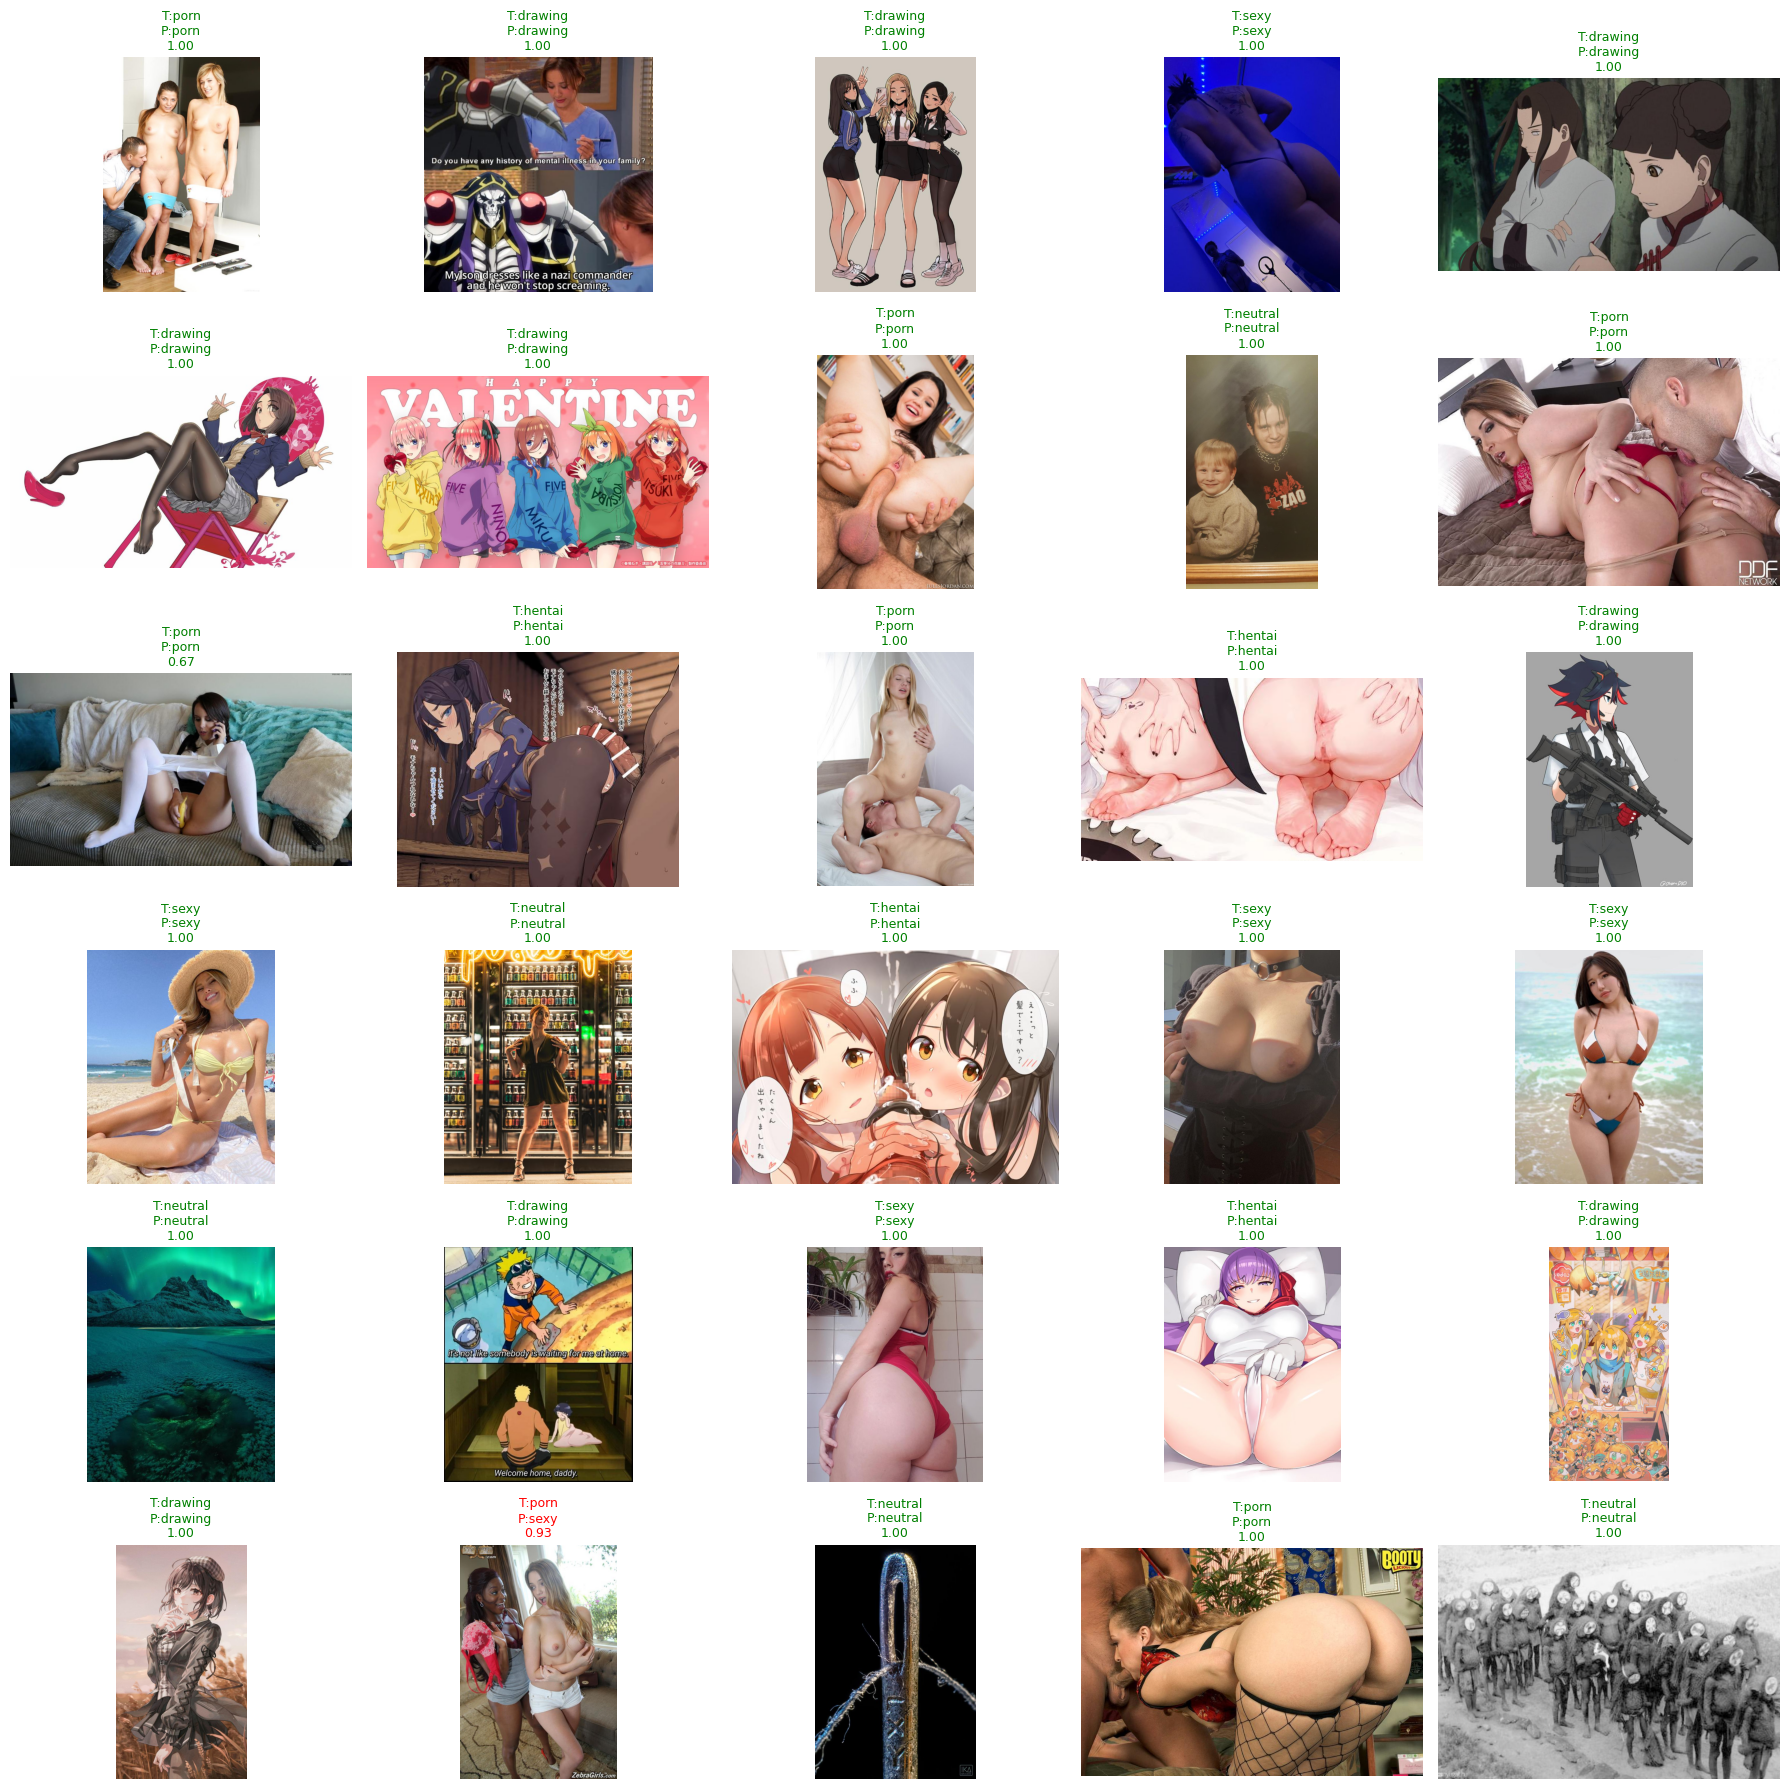


=== RANDOM TEST RESULTS ===
OK | True: porn       Pred: porn       Conf: 1.000 | /content/drive/MyDrive/dataset_nsfw_lite/porn/3bd8d6d7c341f13a89a26c7f707b7b230b1a24a33897166343fe0f3ca9f948ee.jpg
OK | True: drawing    Pred: drawing    Conf: 1.000 | /content/drive/MyDrive/dataset_nsfw_lite/drawing/2a90fd5c007eb307d42ed020130ad7257c9f7ac78260e53267cab913631dd478.jpg
OK | True: drawing    Pred: drawing    Conf: 1.000 | /content/drive/MyDrive/dataset_nsfw_lite/drawing/0c04dd26b963b3840779e2b74ef3328e6f08fe93b163b51932c7439c944ec27e.jpg
OK | True: sexy       Pred: sexy       Conf: 1.000 | /content/drive/MyDrive/dataset_nsfw_lite/sexy/Copy of e491770eeda7e32daef151774405df5a2d874b1535438ce1782efee189ccaa13.jpg
OK | True: drawing    Pred: drawing    Conf: 0.996 | /content/drive/MyDrive/dataset_nsfw_lite/drawing/4a51aae770d429886fbd0c80eff714107e82e110f2d80f8dcd51fff04a415039.jpg
OK | True: drawing    Pred: drawing    Conf: 1.000 | /content/drive/MyDrive/dataset_nsfw_lite/drawing/ee6ff561f031

In [14]:
# ================= RANDOM TEST PREDICTION (30 IMAGES) =================
import random
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

model.eval()
model.to(model.device)

TEST_ROOT = DATASET_PATH  # root dataset folder

# Collect all image paths
all_images = []
for root, dirs, files in os.walk(TEST_ROOT):
    for f in files:
        if f.lower().endswith(('jpg','jpeg','png','webp')):
            all_images.append(os.path.join(root, f))

print("Total images found:", len(all_images))

# Random sample 30 images
sample_imgs = random.sample(all_images, 30)

pred_results = []

with torch.no_grad():
    for img_path in sample_imgs:
        img = Image.open(img_path).convert("RGB")

        # transform
        x = val_tf(img).unsqueeze(0).to(model.device)

        # predict
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        pred_idx = torch.argmax(probs).item()

        pred_label = class_names[pred_idx]
        confidence = probs[pred_idx].item()

        true_label = os.path.basename(os.path.dirname(img_path))

        pred_results.append((img_path, true_label, pred_label, confidence))

# ================= VISUALIZE =================
plt.figure(figsize=(18, 18))
for i, (img_path, true_label, pred_label, conf) in enumerate(pred_results):
    plt.subplot(6, 5, i+1)
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.axis('off')

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"T:{true_label}\nP:{pred_label}\n{conf:.2f}", color=color, fontsize=9)

plt.tight_layout()
plt.show()

# ================= PRINT RESULT TABLE =================
print("\n=== RANDOM TEST RESULTS ===")
for img_path, t, p, c in pred_results:
    status = 'OK' if t == p else 'WRONG'
    print(f"{status} | True: {t:<10} Pred: {p:<10} Conf: {c:.3f} | {img_path}")

In [16]:
# ================= FIX DEPENDENCIES =================
!pip install -q onnx onnxscript openvino openvino-dev

# ================= OPENVINO EXPORT =================
import torch
import openvino as ov
import os
import numpy as np

EXPORT_DIR = "/content/drive/MyDrive/openvino_ghostnet"
os.makedirs(EXPORT_DIR, exist_ok=True)

# ========== STEP 1: PyTorch -> ONNX ==========
onnx_path = os.path.join(EXPORT_DIR, "ghostnet_nsfw.onnx")

model.eval()
model.cpu()  # safest for export

dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

torch.onnx.export(
    model.model,          # GhostNet backbone
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=13,
    dynamic_axes={
        "input": {0: "batch"},
        "output": {0: "batch"}
    }
)

print("ONNX exported:", onnx_path)

# ========== STEP 2: ONNX -> OpenVINO IR ==========
core = ov.Core()
ov_model = core.read_model(onnx_path)

xml_path = os.path.join(EXPORT_DIR, "ghostnet_nsfw.xml")
bin_path = os.path.join(EXPORT_DIR, "ghostnet_nsfw.bin")

ov.save_model(ov_model, xml_path)

print("\nOpenVINO model saved:")
print("XML:", xml_path)
print("BIN:", bin_path)

# ========== STEP 3: Quick OpenVINO Test ==========
compiled_model = core.compile_model(xml_path, "CPU")
infer_request = compiled_model.create_infer_request()

test_input = np.random.rand(1,3,IMG_SIZE,IMG_SIZE).astype(np.float32)
result = infer_request.infer({"input": test_input})

print("\nOpenVINO inference output shape:", list(result.values())[0].shape)
print("OpenVINO export success ✅")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 6.5 MB/s eta 0:00:00


/tmp/ipython-input-3059302669.py:21: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0217 09:55:15.923000 1492 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 13 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0217 09:55:16.904000 1492 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, al

[torch.onnx] Obtain model graph for `GhostNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `GhostNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 120, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 115, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

Applied 224 of general pattern rewrite rules.
ONNX exported: /content/drive/MyDrive/openvino_ghostnet/ghostnet_nsfw.onnx

OpenVINO model saved:
XML: /content/drive/MyDrive/openvino_ghostnet/ghostnet_nsfw.xml
BIN: /content/drive/MyDrive/openvino_ghostnet/ghostnet_nsfw.bin

OpenVINO inference output shape: (1, 5)
OpenVINO export success ✅
